In [1]:
import sys

sys.path.append('../../')
from msBO import MultiStateBO
from msBO.objective import BPMvar_minimization

import numpy as np
import matplotlib.pyplot as plt
import torch
from IPython.display import display

sys.path.append('../../../machineIO/')
from machineIO import construct_machineIO, Evaluator, StatefulOracleEvaluator
io = construct_machineIO()

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

# import importlib, msBO  # or from boom import msBO if that's your import
# importlib.reload(msBO)

Failed to import 'phantasy'


In [2]:
n_init = 16
n_each = 4
beta = 4

In [3]:
n_control = 4
n_bpm = 3
n_monitor = n_bpm*2
n_task = n_bpm+1
n_state = 3
n_state_pvs = 1

control_CSETs = [f'X{i+1}:I_CSET' for i in range(n_control)]
control_RDs  = [f'X{i+1}:I_RD' for i in range(n_control)]
control_tols = [0.1]*len(control_CSETs)
control_min  = [ 0.0]*len(control_CSETs)
control_max  = [ 1.0]*len(control_CSETs)
bpm_xRDs     = [f'BPM{i}:XPOS_RD' for i in range(n_bpm)]
bpm_magRDs   = [f'BPM{i}:MAG_RD' for i in range(n_bpm)]
monitor_RDs  = bpm_xRDs + bpm_magRDs
bare_monitor_RDs  = [f'Y{i+1}' for i in range(len(monitor_RDs))]
state_CSETs  = [f'X{i+1+n_control}:I_CSET' for i in range(n_state_pvs)]
state_RDs    = [f'X{i+1+n_control}:I_RD' for i in range(n_state_pvs)]
state_tols   = [0.1]*len(state_CSETs)
state_min    = [0.0]*n_state_pvs
state_max    = [n_state-1]*n_state_pvs
state_key_vals  = {f'state{s}':[float(s)]*n_state_pvs for s in range(n_state)}
oracle_key_names = {'x':control_RDs,
                    'y':bpm_xRDs + ['BPM:MAG_min_ratio']}
states = list(state_key_vals.keys())

In [4]:
def simEPICS_df_transform(df):
    for i,bpm_xRD in enumerate(bpm_xRDs):
        df[bpm_xRD] = df[f'Y{i+1}']
    for i,bpm_magRD in enumerate(bpm_magRDs):
        df[bpm_magRD] = 0.01*df[f'Y{i+len(bpm_xRDs)+1}'] + 1
    return df

In [5]:
ev= Evaluator(
    io,
    control_CSETs= control_CSETs+state_CSETs,
    control_RDs  = control_RDs+state_RDs,
    control_tols = control_tols+state_tols,
    monitor_RDs  = bare_monitor_RDs,
    df_manipulators = [simEPICS_df_transform],
)

In [6]:
x0 = np.random.rand(len(control_CSETs))*(np.asarray(control_max) - np.asarray(control_min)) + np.asarray(control_min)
print("x0",x0)
BPM_MAGs_ref = {}
for s,v in state_key_vals.items():
    future = ev.submit(np.concatenate([x0,v]))
    data, ramping_data = ev.get_result(future)
    y = data[bpm_magRDs].mean().values
    BPM_MAGs_ref[s] = y
BPM_MAGs_ref

x0 [0.5488135  0.71518937 0.60276338 0.54488318]


{'state0': array([1.0096944 , 0.99480537, 0.9901634 ]),
 'state1': array([1.00999819, 0.99007898, 0.9961108 ]),
 'state2': array([1.01001553, 0.9900567 , 1.00636754])}

In [7]:
def BPM_MAG_obj(df,s):
    df['BPM:MAG_min_ratio'] = (df[bpm_magRDs].values/BPM_MAGs_ref[s][None,:]).min()
    return df

In [8]:
oracleEvaluator = StatefulOracleEvaluator(
    io,
    control_CSETs= control_CSETs,
    control_RDs  = control_RDs,
    control_tols = control_tols,
    state_CSETs  = state_CSETs,
    state_RDs    = state_RDs,
    state_tols   = state_tols,
    state_key_vals = state_key_vals,
    oracle_key_names = oracle_key_names,
    monitor_RDs  = bare_monitor_RDs,
    df_manipulators = [simEPICS_df_transform],
    state_df_manipulators = [BPM_MAG_obj],
)

In [9]:
composite_objective_function = BPMvar_minimization(S=n_state, J=n_task)

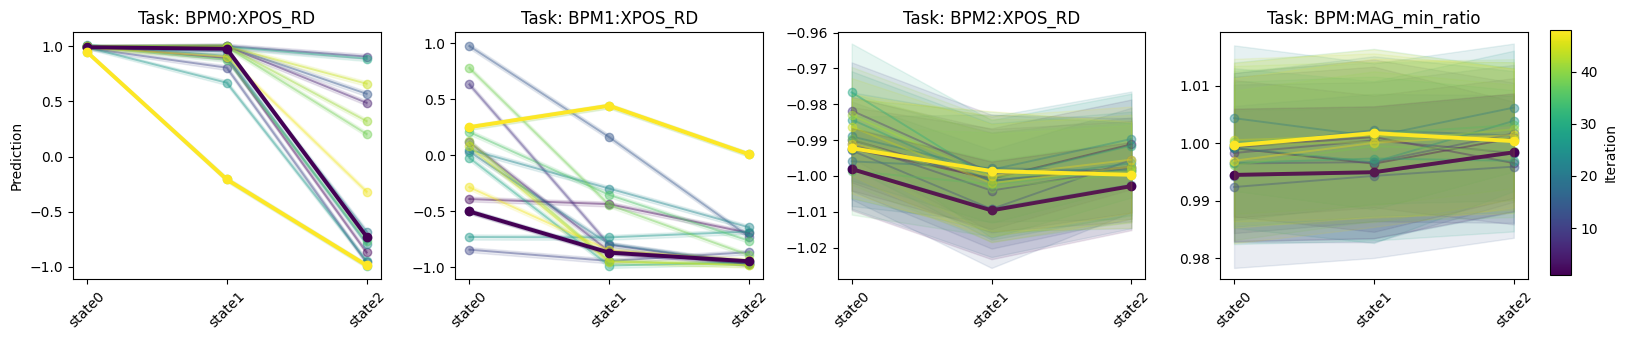

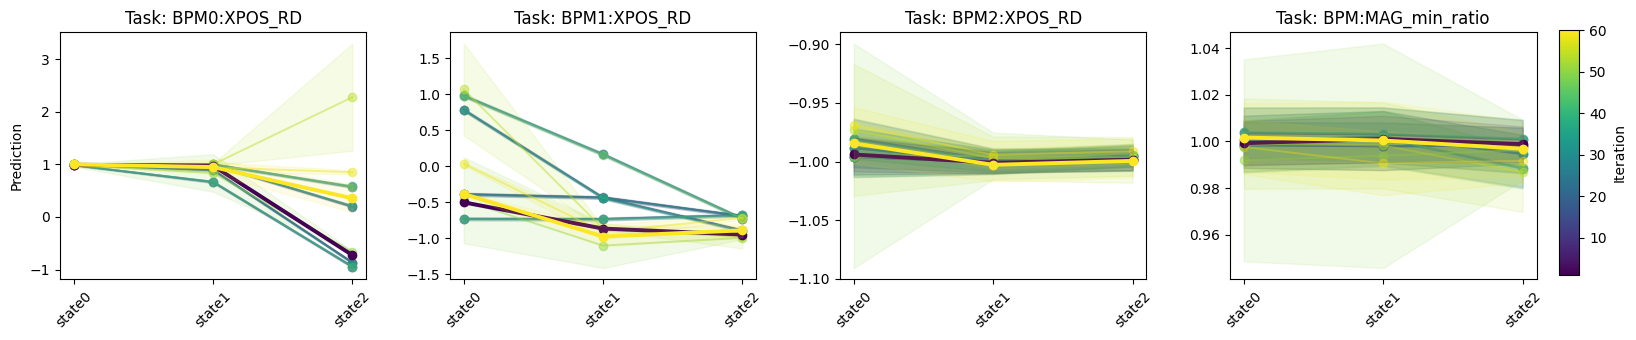

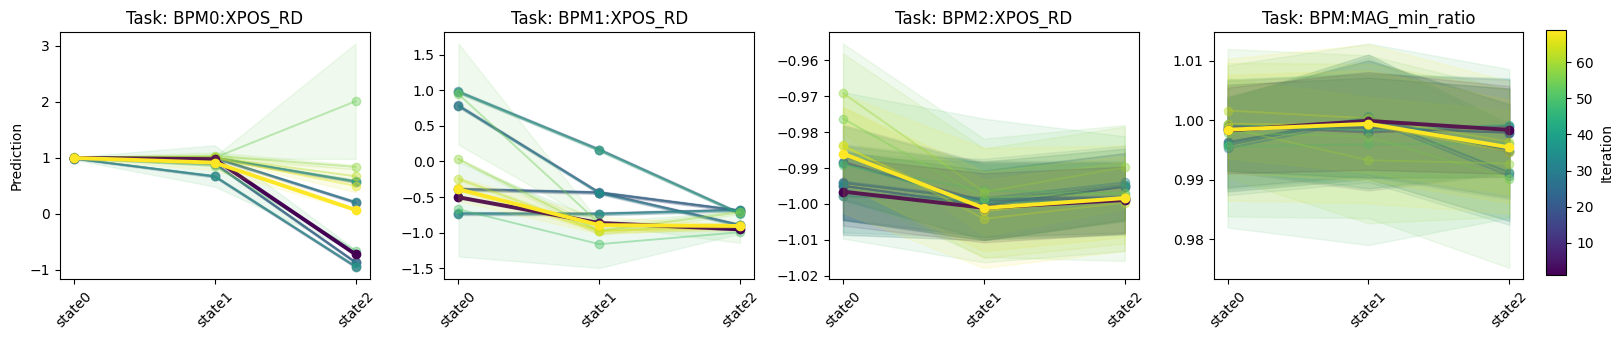

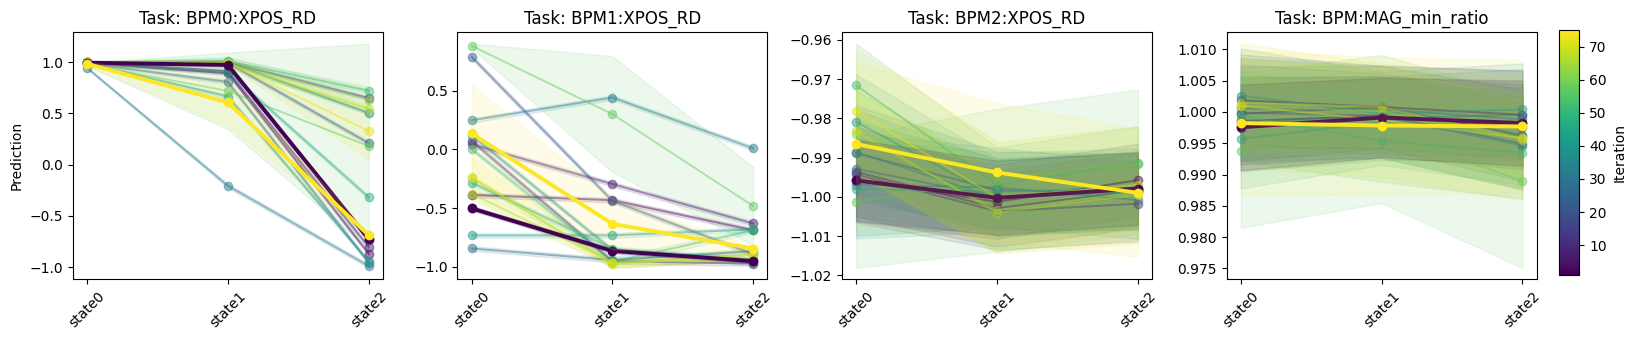

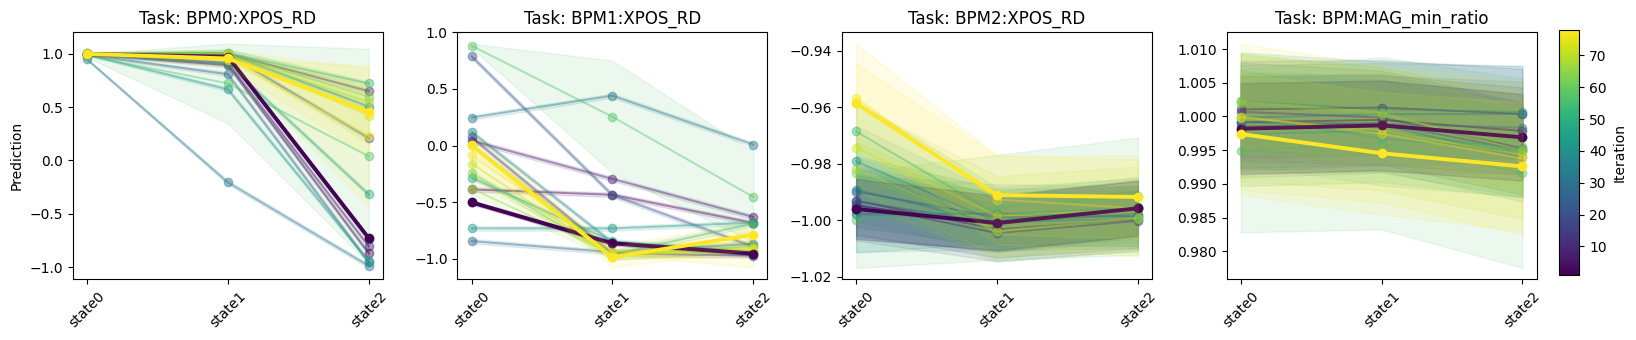

In [10]:
acq_type = 'EI'
fix_acq_state = False
local_optimization=False

np.random.seed(seed)
torch.manual_seed(seed)
oracleEvaluator(x=x0,s=states[0])

msbo = MultiStateBO(
    states = states,
    tasks  = oracle_key_names['y'], 
    control_min = control_min,
    control_max = control_max,
    multistate_oracle_evaluator = oracleEvaluator,
    composite_objective_function = composite_objective_function,
    local_bound_size = 0.1*(np.asarray(control_max) - np.asarray(control_min))
    )
msbo.init(n_init=n_init, local_optimization=local_optimization)
fig, axes = msbo.plot_state_predictions_history()
plt.show()

for s in states[::-1]:
    for i in range(n_each):
        msbo.step(s=s, local_optimization=local_optimization, acq_type=acq_type, fix_acq_state = fix_acq_state, beta=beta)
fig, axes = msbo.plot_state_predictions_history()
plt.show()
for s in states:
    for i in range(n_each-1):
        msbo.step(s=s, local_optimization=local_optimization, acq_type=acq_type, fix_acq_state = fix_acq_state, beta=beta)
fig, axes = msbo.plot_state_predictions_history()
plt.show()
for s in states:
    for i in range(n_each-2):
        msbo.step(s=s, local_optimization=local_optimization, acq_type=acq_type, fix_acq_state = fix_acq_state, beta=beta)
fig, axes = msbo.plot_state_predictions_history()
plt.show()
for s in states[::-1]:
    for i in range(n_each-3):
        msbo.step(s=s, local_optimization=local_optimization, acq_type=acq_type, fix_acq_state = fix_acq_state, beta=beta)
fig, axes = msbo.plot_state_predictions_history()
plt.show()
# iters, means, stds = msbo.virtual_composite_history()

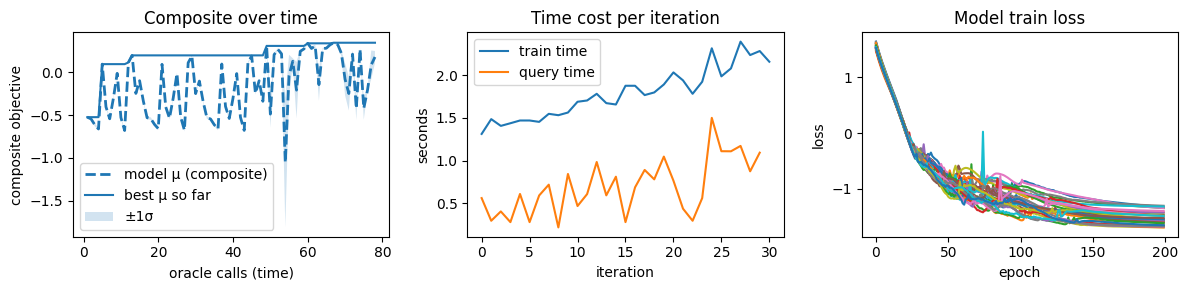

In [11]:
fig,ax, mean = msbo.plot_composite_objective()

In [12]:
fig,ax = msbo.plot_acq_loss_history()

No torch acquisition loss history found.
